# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

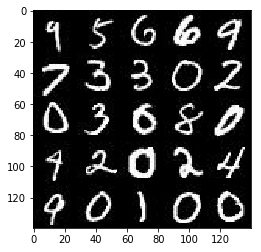

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

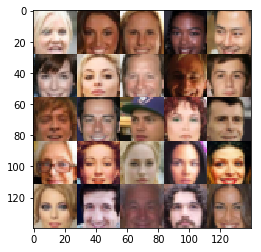

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32)

    return real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [140]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.1
        
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(alpha * x, x)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 7x7x128
        
        x = tf.nn.dropout(x, keep_prob=0.8)
        
        # Flatten it
        flat = tf.reshape(x, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [134]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.1
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [141]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)* np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [142]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [143]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [144]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images*2,
                                                     input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images*2, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.3638... Generator Loss: 0.1723
Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.7192
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.5565... Generator Loss: 0.4626
Epoch 1/2... Discriminator Loss: 1.8421... Generator Loss: 0.3950
Epoch 1/2... Discriminator Loss: 1.6580... Generator Loss: 0.3599
Epoch 1/2... Discriminator Loss: 1.7626... Generator Loss: 0.3278
Epoch 1/2... Discriminator Loss: 1.7237... Generator Loss: 0.2692
Epoch 1/2... Discriminator Loss: 1.7451... Generator Loss: 0.3390


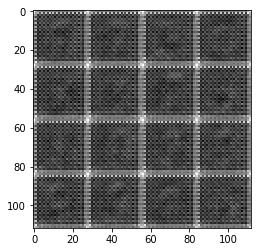

Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 0.8104
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.2320... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.9056... Generator Loss: 0.2915
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.4770
Epoch 1/2... Discriminator Loss: 1.3077... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.6307... Generator Loss: 0.3461
Epoch 1/2... Discriminator Loss: 1.4999... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.5776
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.5448


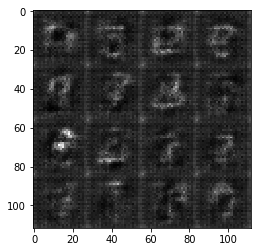

Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 0.4420
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.4272... Generator Loss: 0.4209
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 1.1370
Epoch 1/2... Discriminator Loss: 1.3818... Generator Loss: 0.7226


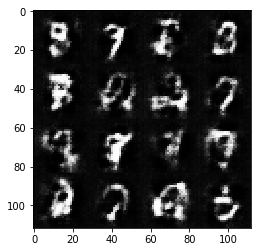

Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.7407
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 1.2965
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.5825
Epoch 1/2... Discriminator Loss: 1.4466... Generator Loss: 0.4663
Epoch 1/2... Discriminator Loss: 1.5507... Generator Loss: 0.5349
Epoch 1/2... Discriminator Loss: 1.2866... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 0.4684
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.8914
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 1.2046
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.9624


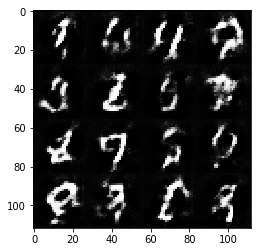

Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.6960
Epoch 1/2... Discriminator Loss: 1.4932... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.9471
Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 0.6278
Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.4103
Epoch 1/2... Discriminator Loss: 1.6761... Generator Loss: 0.4125
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.6176
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 1.3829
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.5456


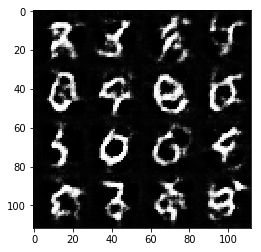

Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.6284
Epoch 1/2... Discriminator Loss: 1.4981... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 1.1298
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.5716... Generator Loss: 0.4199
Epoch 1/2... Discriminator Loss: 1.4072... Generator Loss: 0.4501
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.5818... Generator Loss: 0.4581


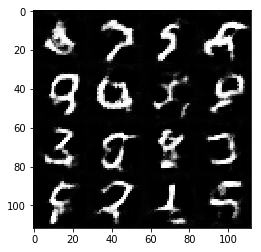

Epoch 1/2... Discriminator Loss: 1.5178... Generator Loss: 0.4193
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.4914
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.4979
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 0.6388
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.5930
Epoch 1/2... Discriminator Loss: 1.7111... Generator Loss: 0.3479
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.5089
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 0.4088
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.4466
Epoch 1/2... Discriminator Loss: 1.3906... Generator Loss: 0.6087


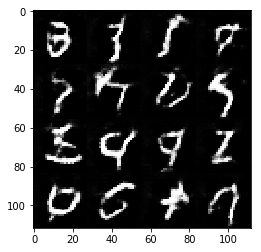

Epoch 1/2... Discriminator Loss: 1.4445... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.5317... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.9635
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 1.1618
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.5684
Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.4135
Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.4310
Epoch 1/2... Discriminator Loss: 1.4704... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.4810... Generator Loss: 0.7364


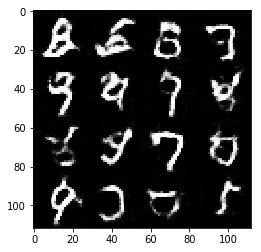

Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 1.1788
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.7121
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.7108
Epoch 1/2... Discriminator Loss: 1.4969... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 1.0802
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.7964
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.5688
Epoch 1/2... Discriminator Loss: 1.6381... Generator Loss: 0.3446
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 0.4245


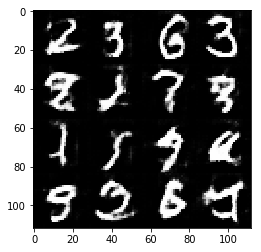

Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.3381... Generator Loss: 1.0285
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 1.0808
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 1.3522... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 1.3550... Generator Loss: 0.5712
Epoch 1/2... Discriminator Loss: 1.3907... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.5642


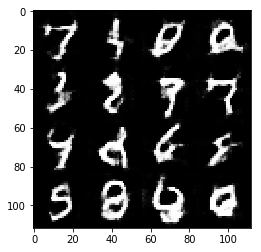

Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.4122... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.6471... Generator Loss: 0.3105
Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.5597
Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.8100
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.6359
Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 0.4799
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.5847


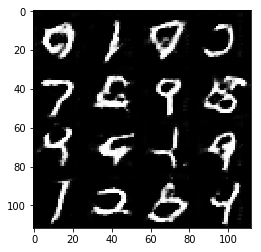

Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 1.4614... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.6373
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.5399
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.5325
Epoch 1/2... Discriminator Loss: 1.6426... Generator Loss: 0.3689
Epoch 1/2... Discriminator Loss: 1.3855... Generator Loss: 0.6031
Epoch 1/2... Discriminator Loss: 1.5320... Generator Loss: 0.8911
Epoch 1/2... Discriminator Loss: 1.3772... Generator Loss: 0.5442


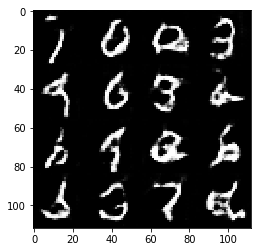

Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 0.5600
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 1.3921... Generator Loss: 0.5120
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.4994
Epoch 1/2... Discriminator Loss: 1.8381... Generator Loss: 0.2993
Epoch 1/2... Discriminator Loss: 1.3439... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.7058


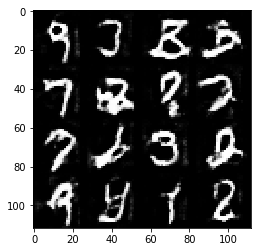

Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.4304
Epoch 1/2... Discriminator Loss: 1.4434... Generator Loss: 0.5485
Epoch 1/2... Discriminator Loss: 1.5103... Generator Loss: 0.5325
Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.5628
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.3275... Generator Loss: 0.5489
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.7940
Epoch 1/2... Discriminator Loss: 1.2680... Generator Loss: 0.8622
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.7055


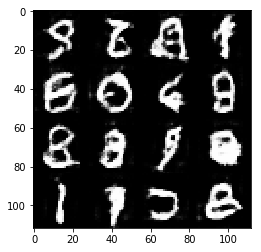

Epoch 1/2... Discriminator Loss: 1.2748... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.3445... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.5606... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.3295... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 1.3723... Generator Loss: 0.6704
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.4785
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 0.8614


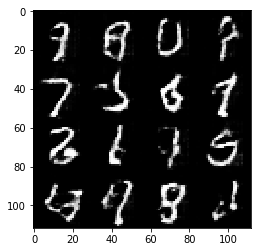

Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.7429
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 1.5000... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.4965
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.3783... Generator Loss: 0.7628


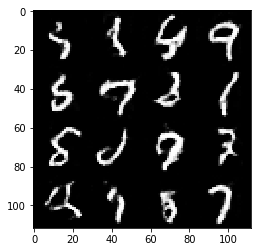

Epoch 1/2... Discriminator Loss: 1.6074... Generator Loss: 1.2131
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 1.4875... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.4738
Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.3036... Generator Loss: 0.7437


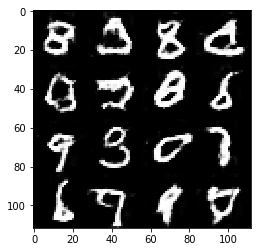

Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.9262... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.9563
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 1.3228... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.2679... Generator Loss: 0.6911


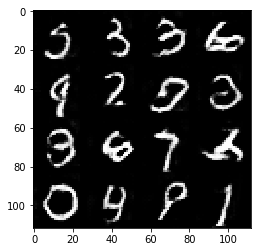

Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.8700
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.8449
Epoch 1/2... Discriminator Loss: 1.2619... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.9923
Epoch 1/2... Discriminator Loss: 1.2502... Generator Loss: 0.8799
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.7274
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 1.0655


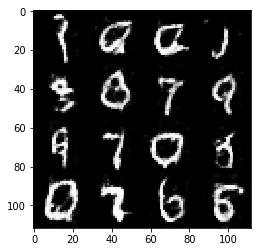

Epoch 2/2... Discriminator Loss: 1.3806... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.6108
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 1.3638... Generator Loss: 0.7380
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.3918... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.5718
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 1.2897


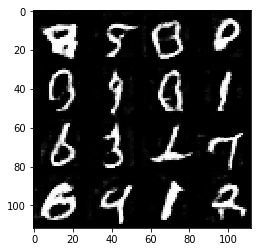

Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.2074... Generator Loss: 0.6330
Epoch 2/2... Discriminator Loss: 1.8168... Generator Loss: 0.2189
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.2691... Generator Loss: 0.8012
Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.2755... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.3283... Generator Loss: 0.7489
Epoch 2/2... Discriminator Loss: 1.4181... Generator Loss: 0.4835
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.5228


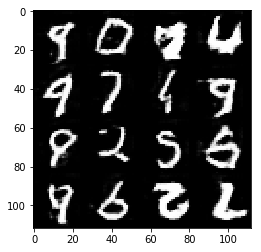

Epoch 2/2... Discriminator Loss: 1.5484... Generator Loss: 0.3548
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 1.4346... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.6697
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.6874
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.7062
Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 0.4553


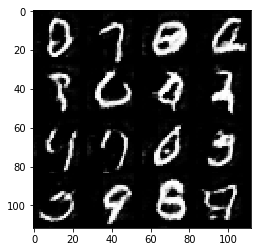

Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.5533
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.3428... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 1.0470
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.5730
Epoch 2/2... Discriminator Loss: 1.3411... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.4479
Epoch 2/2... Discriminator Loss: 1.4772... Generator Loss: 0.6137


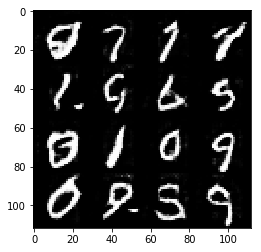

Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.4182... Generator Loss: 0.5356
Epoch 2/2... Discriminator Loss: 1.6944... Generator Loss: 0.3515
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.8175
Epoch 2/2... Discriminator Loss: 1.3993... Generator Loss: 0.5644
Epoch 2/2... Discriminator Loss: 1.2675... Generator Loss: 0.9366
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.7740
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 1.2370


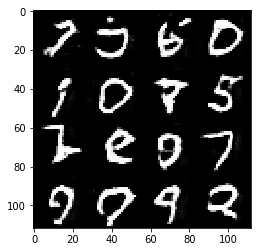

Epoch 2/2... Discriminator Loss: 1.3219... Generator Loss: 0.9488
Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 1.3525... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 1.0596
Epoch 2/2... Discriminator Loss: 1.1749... Generator Loss: 1.0146
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 1.2909... Generator Loss: 1.0336
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.5297


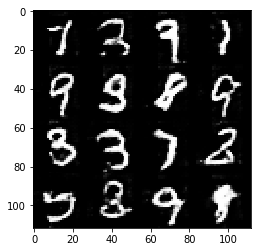

Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.7113
Epoch 2/2... Discriminator Loss: 1.4445... Generator Loss: 0.5582
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.6425
Epoch 2/2... Discriminator Loss: 1.2928... Generator Loss: 0.6467
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.9149
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.8899
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.9177
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.5588
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.8952


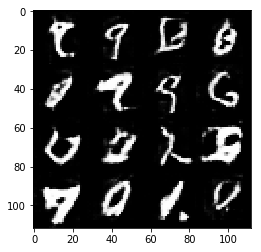

Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.1280... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 1.2116... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 1.3176... Generator Loss: 0.9566
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.6851


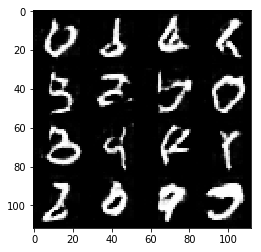

Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 1.0382
Epoch 2/2... Discriminator Loss: 1.5997... Generator Loss: 1.3190
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 1.4210... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.8576
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.8148


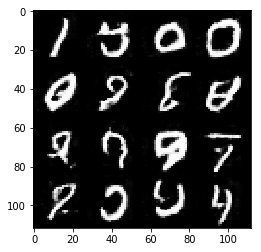

Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.6715
Epoch 2/2... Discriminator Loss: 1.2201... Generator Loss: 0.8094
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.2550... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 1.2729... Generator Loss: 0.5964
Epoch 2/2... Discriminator Loss: 1.2543... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.6881
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.2450... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 1.2932... Generator Loss: 0.9633


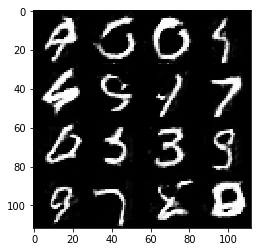

Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.7420
Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.7543
Epoch 2/2... Discriminator Loss: 1.2379... Generator Loss: 0.6705
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.8296
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 1.6473... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.6000


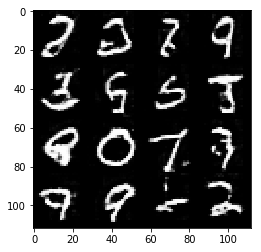

Epoch 2/2... Discriminator Loss: 1.4076... Generator Loss: 0.5944
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.8842
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 1.3939... Generator Loss: 0.5642
Epoch 2/2... Discriminator Loss: 1.2154... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 0.7787
Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 1.3180... Generator Loss: 0.6015


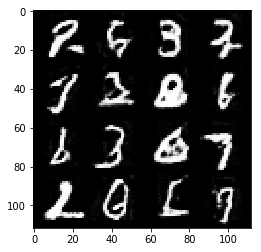

Epoch 2/2... Discriminator Loss: 1.2595... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.2950... Generator Loss: 0.6346
Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.6593... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.8122
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.8835
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.2994... Generator Loss: 0.8680
Epoch 2/2... Discriminator Loss: 1.4340... Generator Loss: 0.8774


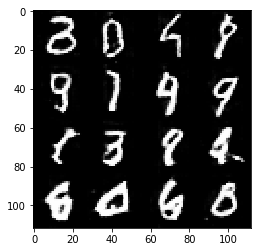

Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.7976
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.9201
Epoch 2/2... Discriminator Loss: 1.2611... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 1.3689... Generator Loss: 0.5579
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.7841
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.6159
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 0.6545


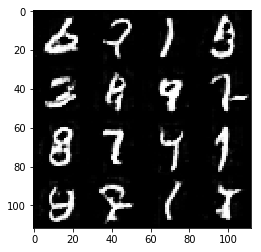

Epoch 2/2... Discriminator Loss: 1.4431... Generator Loss: 0.4905
Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 1.2615... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.6861
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 0.9166
Epoch 2/2... Discriminator Loss: 1.2503... Generator Loss: 0.7916
Epoch 2/2... Discriminator Loss: 1.3009... Generator Loss: 0.8318
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.6152
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 1.1105


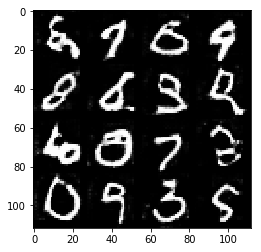

Epoch 2/2... Discriminator Loss: 1.4077... Generator Loss: 0.5226
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 0.8362
Epoch 2/2... Discriminator Loss: 1.2674... Generator Loss: 0.7955
Epoch 2/2... Discriminator Loss: 1.3017... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 0.7699
Epoch 2/2... Discriminator Loss: 1.4058... Generator Loss: 0.5488
Epoch 2/2... Discriminator Loss: 1.6402... Generator Loss: 0.3401
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.4132... Generator Loss: 0.7924


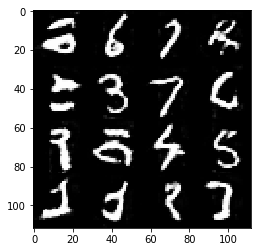

Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.8664
Epoch 2/2... Discriminator Loss: 1.2694... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.6267
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 1.2400
Epoch 2/2... Discriminator Loss: 1.1745... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 0.6201
Epoch 2/2... Discriminator Loss: 1.3158... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 0.8783


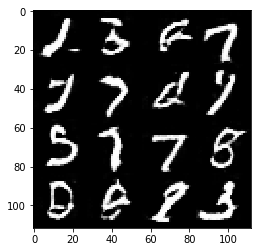

Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.3758... Generator Loss: 0.5492
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.8769
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.5776
Epoch 2/2... Discriminator Loss: 2.2172... Generator Loss: 0.1634
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.6492
Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 0.9234


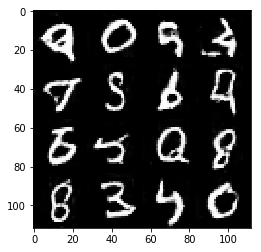

Epoch 2/2... Discriminator Loss: 1.2522... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.3061... Generator Loss: 0.5572
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.5545
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 0.7518
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.9352


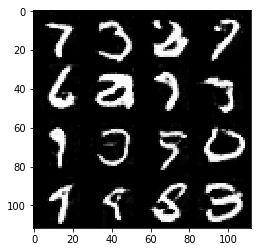

In [145]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2038... Generator Loss: 0.0382
Epoch 1/1... Discriminator Loss: 2.1138... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 2.1309... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.4096
Epoch 1/1... Discriminator Loss: 1.8951... Generator Loss: 0.4027
Epoch 1/1... Discriminator Loss: 1.7276... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 1.8773... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.7808... Generator Loss: 0.5427


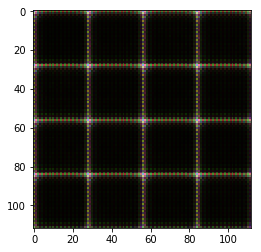

Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.7953... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 1.8160... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 1.0279
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 1.6528
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.9178


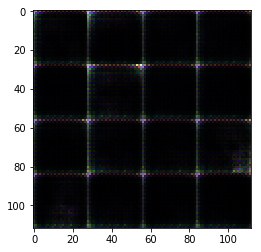

Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 1.2517
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.6406... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 1.2609


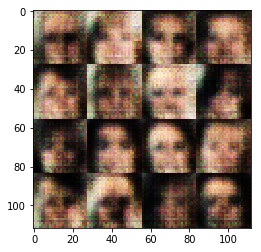

Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 1.3539
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.2617
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9352
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 1.2690


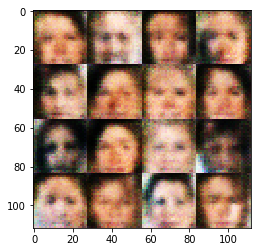

Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.4579
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.4054
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.8934


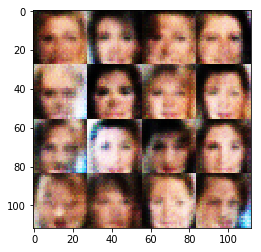

Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 1.5242
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 1.6073
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 1.8332
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.3926
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.7394
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.5551


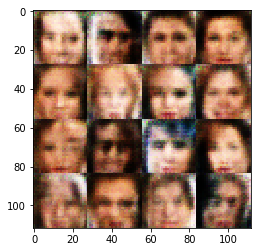

Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.9902... Generator Loss: 0.3055
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.4839
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 2.1314
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 1.4793
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.3977


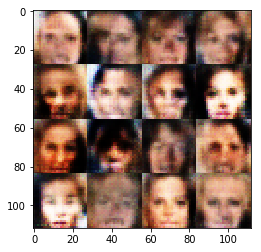

Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.8940... Generator Loss: 0.2810
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.3803


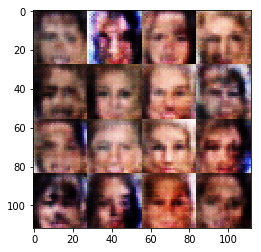

Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 1.2521
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 1.5948
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.7217... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.6893


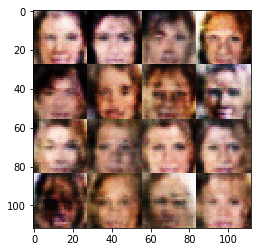

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.5651
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 1.7068
Epoch 1/1... Discriminator Loss: 1.6557... Generator Loss: 0.4123
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.0299


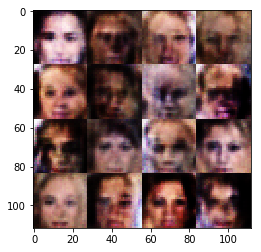

Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.6173... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.4450
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.4068


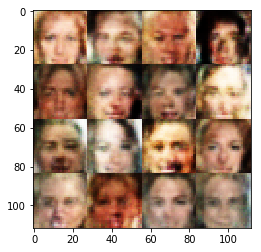

Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.6349
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 1.1471


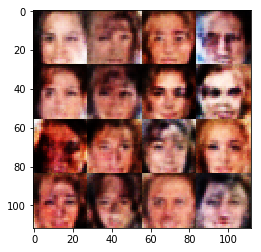

Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.5133
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.4780
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.1087
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.0378


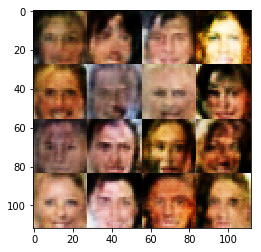

Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 1.2738
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 1.3408
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.8114... Generator Loss: 0.3351
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.9941
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 1.9050


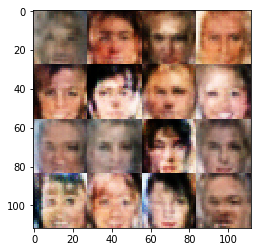

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.2494
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1737
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 1.2018
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8968


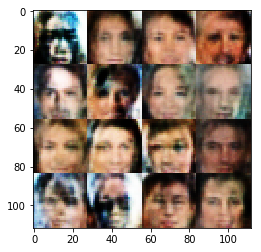

Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.7123... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 0.6092


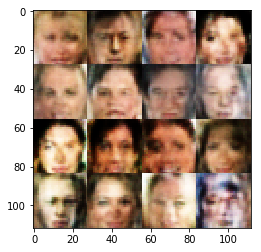

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.6029
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 1.3228
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.8467


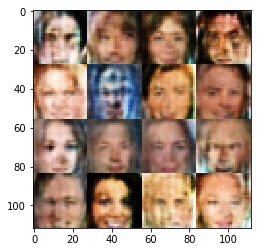

Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.4941... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5535
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.8497


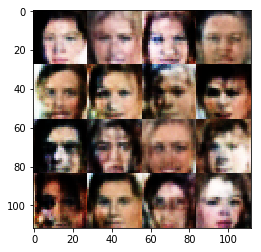

Epoch 1/1... Discriminator Loss: 1.6724... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 1.0227
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.3695


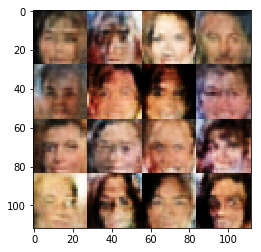

Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 1.1985


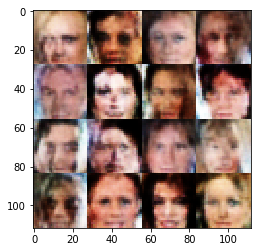

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.1711... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 1.0488
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.9210


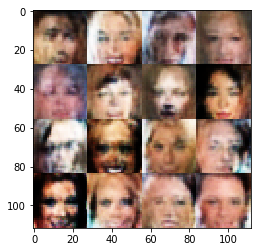

Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.1214
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.4695
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 1.2519


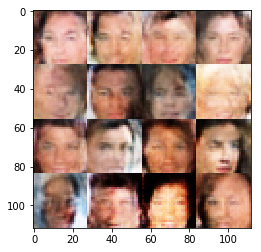

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 1.0249


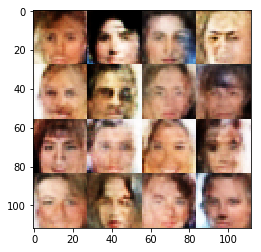

Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 1.3676
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 1.0199


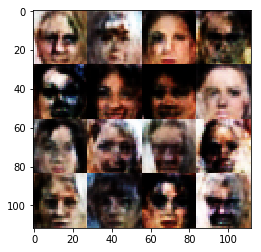

Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.6744
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.7454


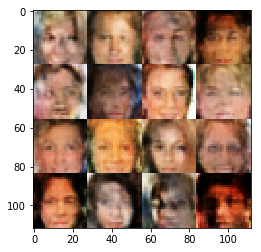

Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.2343
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7872


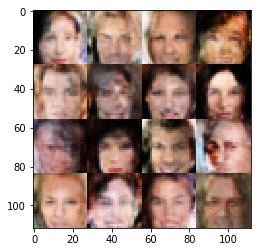

Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8720


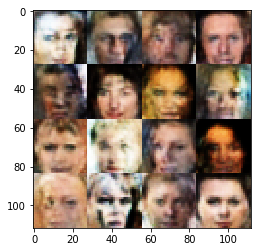

Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 1.1879
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8884


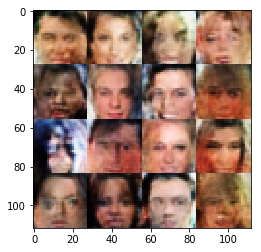

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6352


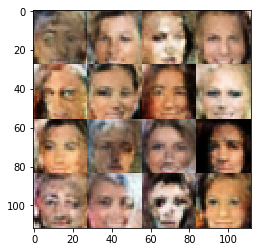

Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 1.0596
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6029


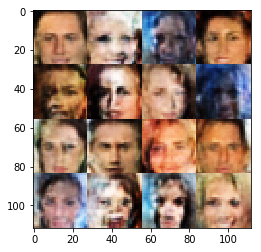

Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 1.0509


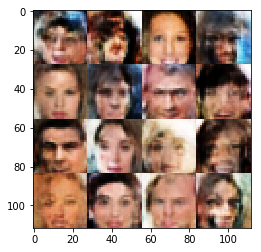

Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 1.1638
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 1.1012


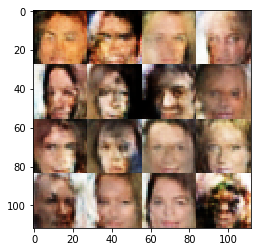

Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4687... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8931


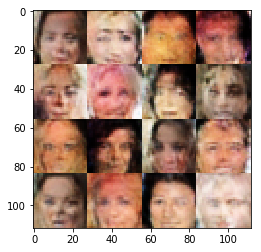

Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.9479


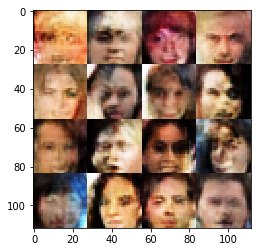

Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8775


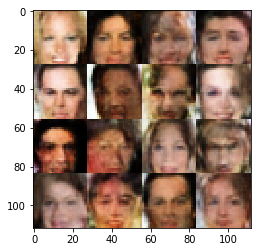

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 1.0330
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.0398
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7092


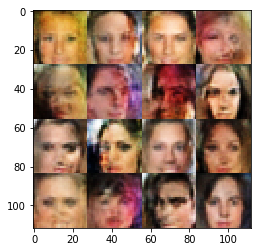

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8801


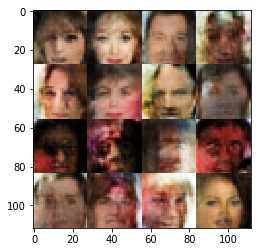

Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9514
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.9460
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.9307


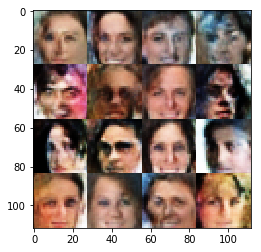

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8002


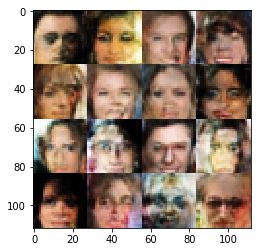

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.2871


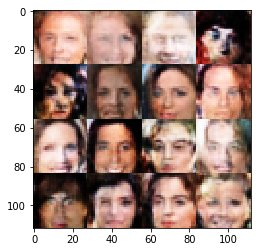

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.5218... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.9390


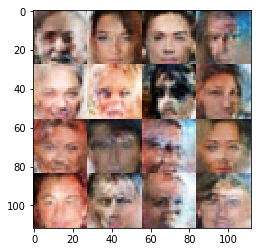

Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7815


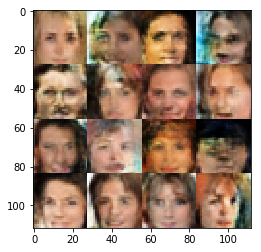

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8946


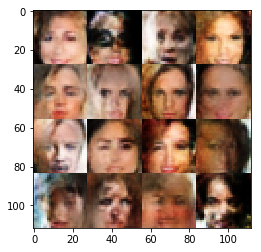

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6957


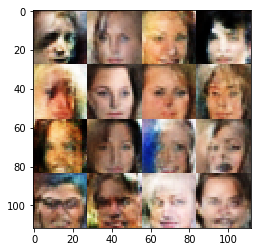

Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8439


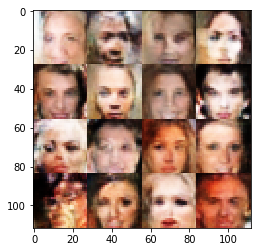

Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7927


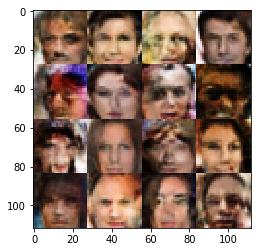

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.9108


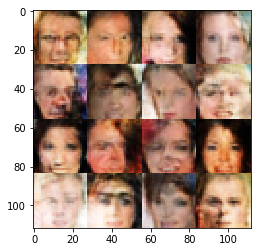

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6883


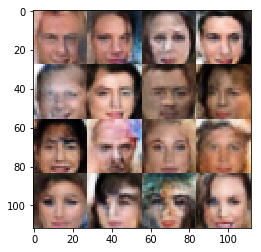

Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7967


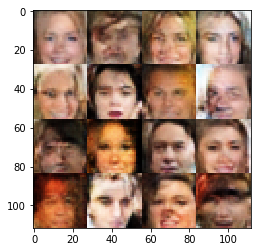

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8682


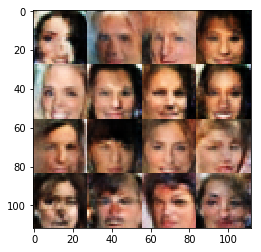

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.9435


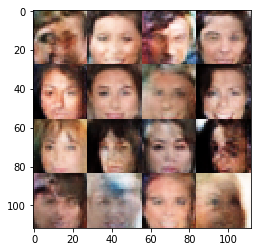

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.8435


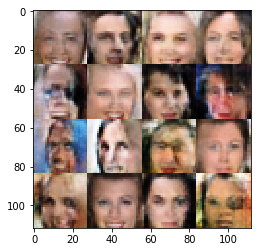

Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.8485


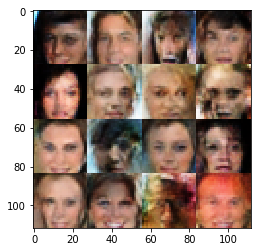

Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7250


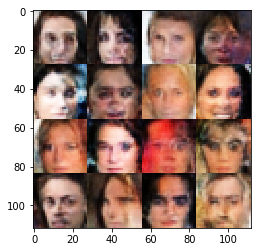

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7354


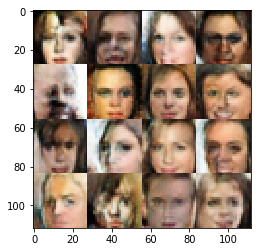

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.5166... Generator Loss: 0.5746


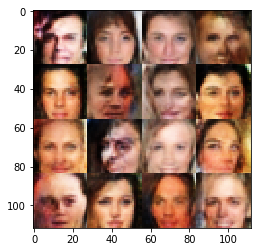

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.6499


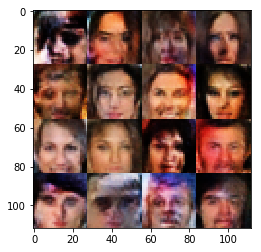

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8283


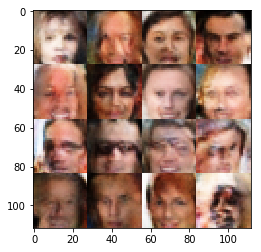

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7620


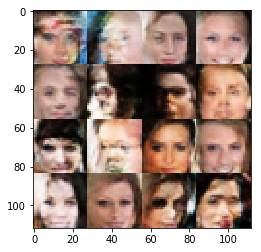

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8358


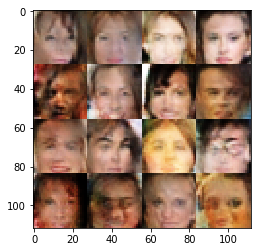

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7284


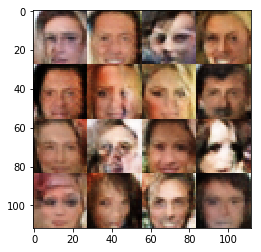

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8051


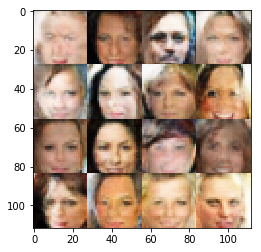

Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8057


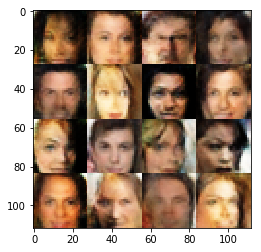

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7338


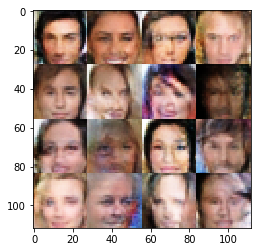

In [146]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.